# Initial testbed for the project

In [4]:
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
# This just ensures some comments in dataframes below display nicely
import pandas as pd
from iminuit import cost,Minuit
from numpy.lib import recfunctions as rfn
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = None
pd.options.mode.chained_assignment = None  # default='warn'

from jacobi import propagate
import strax
import straxen


# Set up the 'context', which loads and processes data for you.
st = straxen.contexts.xenonnt_online(_auto_append_rucio_local=False)
st.storage = [
    strax.DataDirectory('C:/Users/keert/data_100_sec_run\strax_data\026195-raw_records-rfzvpzj4mf', readonly=True),
    # This points to the run database, useful for retrieving run metadata
    st.storage[0],
    # Any new files you make will go here:
    strax.DataDirectory('./data_100_sec_run', provide_run_metadata=False)
]

# The ID of the run you want to load. Only works if you have data available locally.
# (it won't download data for you)
run_id = '026195'

In [5]:
# Get the basic event info.
df = st.get_df(run_id, 'event_info') #to get results as a dataframe

# A description of column headers can be found on straxen.readthedocs.io
df.head()

c:\users\keert\straxen\straxen\url_config.py:743: UserWarning: From straxen version 2.1.0 onward, URLConfig parameters will be sorted alphabetically before being passed to the plugins, this will change the lineage hash for non-sorted URLs. To load data processed with non-sorted URLs, you will need to use an older version.
  warnings.warn(


Loading event_info: |          | 0.00 % [00:00<?]

,time,endtime,cs1,cs1_wo_timecorr,cs2_wo_timecorr,cs2_area_fraction_top_wo_timecorr,cs2_wo_picorr,cs2_area_fraction_top_wo_picorr,cs2_wo_elifecorr,cs2_area_fraction_top_wo_elifecorr,...,alt_s2_z_naive,r_field_distortion_correction,alt_s1_r_field_distortion_correction,alt_s2_r_field_distortion_correction,z_field_distortion_correction,alt_s1_z_field_distortion_correction,alt_s2_z_field_distortion_correction,alt_s1_theta,alt_s2_theta,theta
0,1628071231457718612,1628071231460802040,NaN,NaN,NaN,0.770828,4.859222e+05,0.770828,4.859222e+05,0.770828,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1.832500,-2.244172,-1.832500
1,1628071231767791732,1628071231770557990,0.165009,0.165009,1.384114e+06,0.745757,1.383082e+06,0.745757,1.383082e+06,0.745757,...,-1.448577,-3.494379,NaN,-3.539388,0.0,0.0,0.0,-0.093951,-0.089296,-0.093951
2,1628071231920188672,1628071231922925350,NaN,NaN,NaN,0.771676,3.421937e+05,0.771676,3.421937e+05,0.771676,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-0.989723,-1.034359,-0.989723
3,1628071232181016252,1628071232183750390,NaN,NaN,NaN,0.812644,1.228243e+05,0.812644,1.228243e+05,0.812644,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.037246,2.096820,2.037246
4,1628071232325696682,1628071232328468350,8431.012695,8431.012695,1.649679e+05,0.737456,1.575349e+05,0.737456,1.575349e+05,0.737456,...,-83.077713,7.945467,NaN,8.506552,0.0,0.0,0.0,0.287271,0.264068,0.287271


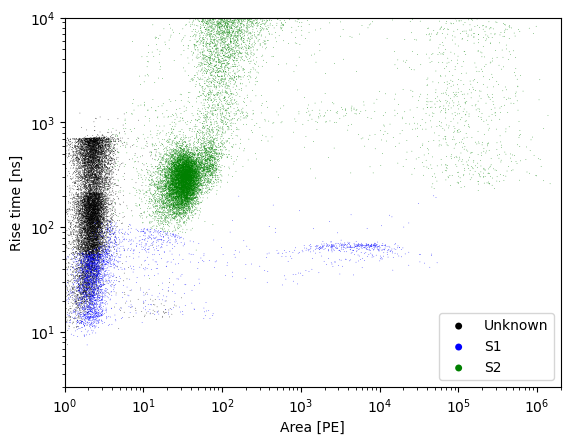

In [8]:
# A basic classification of the peaks in the run
st.plot_peak_classification(run_id)

In [9]:
peaks = st.get_array(run_id, ('peak_basics','peak_positions'))    #to get results as a Structured numpy array just for easier computations

Loading plugins: |          | 0.00 % [00:00<?]

Total time of run

In [10]:
run_time = (int(df["time"].iloc[-1])-int(df["time"].iloc[0]))*1e-9
print("run time:",run_time,"s")

run time: 92.19868516000001 s


In [11]:
def select_area(peaks,xrange,yrange,params=("area","range_50p_area")):
    """
    Makes a selection based on x and y range array based on any two parameters

    peaks = input array of peaks
    xrange = tuple of min and max x-axis values from plot from which data is selected
    yrange = tuple of min and max y-axis values from plot from which data is selected
    params = tuple of column titles in input peaks array of the parameters to be used for selection
    """
    low_x,high_x = xrange
    low_y,high_y = yrange
    param1,param2 = params
    select_peaks = peaks[
    (peaks[param1] > int(low_x))
    & (peaks[param1] < int(high_x))
    & (peaks[param2] > low_y)
    & (peaks[param2] < high_y)]
    return select_peaks

def plot_selection(xrange,yrange,axes,col):
    """Draws the selection as a filled in box on any plot
    
    xrange = tuple of min and max x-axis values from plot from which data is selected
    yrange = tuple of min and max y-axis values from plot from which data is selected
    axes = plot on which selection is to be visualized
    col = color of the filled in box
    """    
    low_x,high_x = xrange
    low_y,high_y = yrange
    x = np.arange(low_x, high_x, 10)
    y = np.full(len(x), low_y)
    y2 = np.full(len(x), high_y)
    axes.fill_between(x, y, y2, alpha=0.5, color=col)
    return axes

Making selections- rest of code for single electron signals is based on the overall array called se_peaks

828
10806


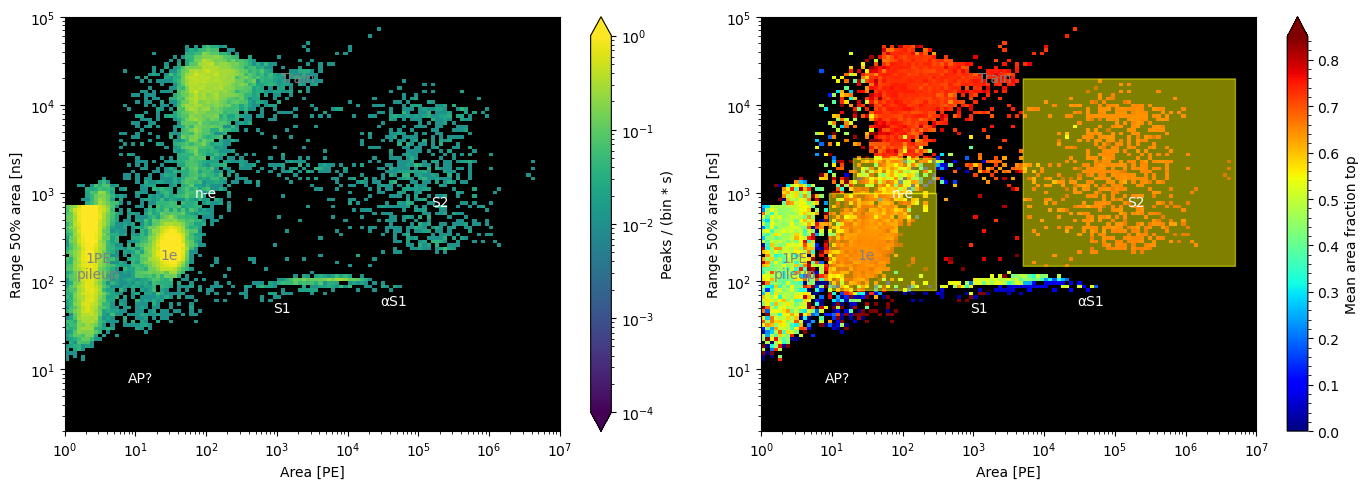

In [12]:
#following function produces two plots:
#1. Bins the peaks based on area and width containing 50% of the peak shape (range_50p_area)
#2. Plots a colourmap of the area, width and area fraction top (AFT) of the peak
#i.e. the fraction of the light seen by the top vs. bottom PMT array
#Both plots includes a classification of the peaks based on these parameters
st.plot_peaks_aft_histogram(run_id)

#Selecting largest S2 peaks from the classification plots
s2_peaks = select_area(peaks,(5e3,5e6),(1.5e2,2e4))

print(len(s2_peaks))

#Selecting regions containing majority single electrons (1e)  from the classification plot
se_peaks1 = select_area(peaks,(9,3e2),(8e1,1e3))  
#Selecting regions containing majority few electrons (ne) from the classification plot
se_peaks2 = select_area(peaks,(2e1,3e2),(1e3,2.5e3))     #include few ne

#visualize selections
ax = plt.gca()

plot_selection((5e3,5e6),(1.5e2,2e4),ax,"yellow")
plot_selection((9,3e2),(8e1,1e3),ax,"yellow")
plot_selection((2e1,3e2),(1e3,2.5e3),ax,"yellow")

#combine se and ne peaks together, arrange by time
se_peaks = np.sort(np.concatenate((se_peaks1, se_peaks2)), order='time')

print(len(se_peaks))

In [9]:
print(np.min(s2_peaks["area"]),np.max(s2_peaks["area"]))
print(np.min(se_peaks["area"]),np.max(se_peaks["area"]))

5043.882 4326509.0
9.008112 275.91495


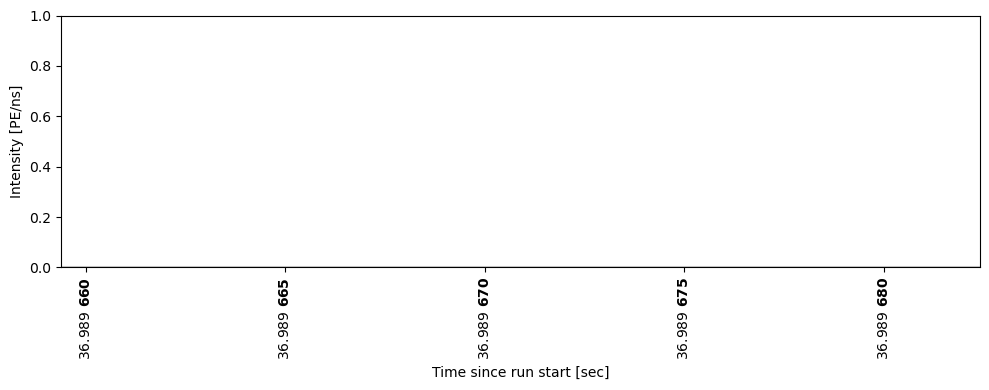

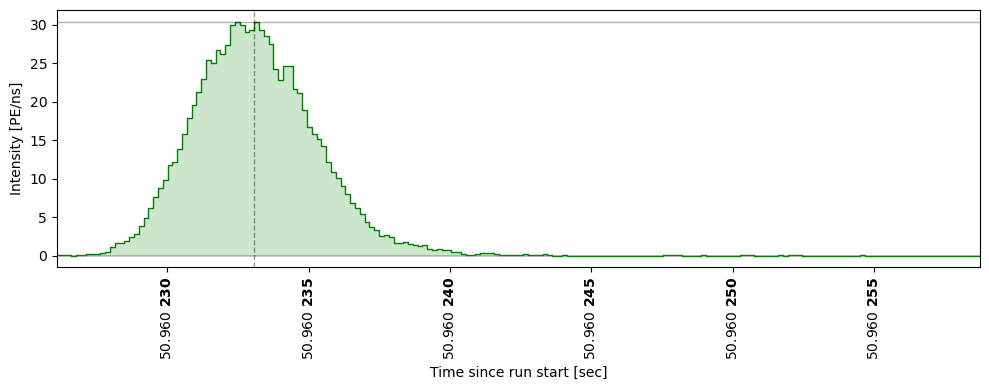

In [10]:
# Plot some random S2 waveforms just to check that they are nice and uniform and big
def plot_some_peaks(peaks, max_plots=3, randomize=False):
    """Plot the first peaks in the input "peaks" collection (max number of 3 by default).
    If randomize is set to True, the function will plot a random selection of peaks.
    """
    if randomize:
        # This randomly takes max_plots in the range (0, len(peaks)). Plot these indices
        indices = np.random.randint(0, len(peaks), max_plots)
    else:
        # Just take the first max_plots peaks in the data
        indices = range(max_plots)
    for i in indices:
        p = peaks[i]
        start, stop = p["time"], p["endtime"]
        st.plot_peaks(run_id, time_range=(start, stop))
        plt.show()

plot_some_peaks(s2_peaks,randomize=True,max_plots=2)


Assigning peaks to the S2 directly before it, and quick study of proporties of the S2

no. of SE peaks assigned to an S2: 10805
mean livetime with double scatter (ms): 111.44995663845222
mean livetime without double scatter (ms): 187.68130450101833
no. of S2s excluding double scatter: 491


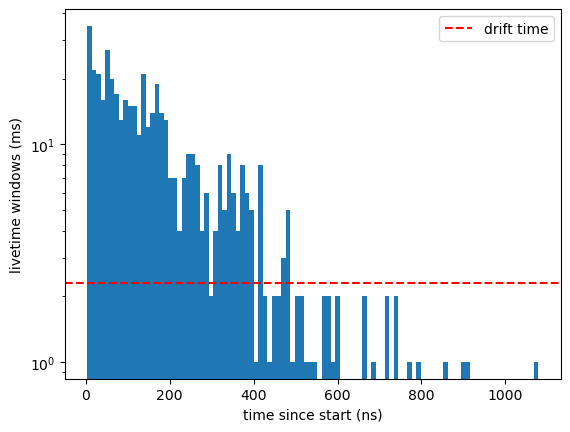

In [17]:
def diffs_s2_to_se(s2_peaks,se_peaks):
    """Assign each se peak to the s2 that comes directly before it in time
    
    s2_peaks = input array of S2 signals with a "time" column 
    se_peaks = input array of SE signals with a "time" column

    Returns three arrays:
    1. The indices of the S2s that each SE has been assigned to
    2. The time differences between each SE and the S2 directly before it
    3. An array of all SE peaks that have been assigned to an S2
    """    
    assigned_indices = np.searchsorted(s2_peaks["time"], se_peaks["time"]) - 1
    valid_indices = assigned_indices[assigned_indices>= 0]                      #basically remove the SEs at the beginning of the run
                                                                                #since otherwise this algorithm would assign it to the S2 at
                                                                                #the end of the run
    se_no_s2 = len(assigned_indices) - len(valid_indices)
    time_diffs = se_peaks["time"][se_no_s2:]-s2_peaks["time"][valid_indices]   #find difference in time of each S2-se pair
    assigned_se_peaks = se_peaks[se_no_s2:]                                    #all se peaks after an S2 in the run
    return valid_indices,time_diffs,assigned_se_peaks

assigned_se_indices,time_diffs_se,se_peaks= diffs_s2_to_se(s2_peaks,se_peaks)   #finding time differences (in ns)
print("no. of SE peaks assigned to an S2:",len(se_peaks))

#----------------
#NOTE: these following are just some metrics I experimented with to explore the dataset
#When plotting rate of electrons w.r.t area or width for example, can choose to see
#how many SEs within 100s, or SEs overall, or total area of all SEs etc. 

#find how many SEs are associated with each S2 within 100ms and scale with lifetime
#NOTE can alternatively also use np.bincount(assigned_se_indices) to find number of SE signals in livetime window
se_per_s2_100ms = np.zeros(len(s2_peaks))                           #finding SEs only 100ms after and dividing by livetime window 
                                                                    #otherwise would bias later SEs
for se_index, s2_index in enumerate(assigned_se_indices):
    if time_diffs_se[se_index] < 100e6:                          #just remove this to include all SEs
        se_per_s2_100ms[s2_index] += 1


livetime_windows = np.diff(s2_peaks["time"])*1e-6
livetime_windows = np.append(livetime_windows,np.nan)                     #convert to ms just to stay consistent

assigned_se_rate = se_per_s2_100ms/livetime_windows #scaled by livetime window

#----------------
#finding total area of assigned SEs per S2
se_totals = np.zeros(len(s2_peaks))
for se_index, s2_index in enumerate(assigned_se_indices):
    # Add the value from the second column of se_peaks to the corresponding s2_peak sum
    if time_diffs_se[se_index] < 100e6:                                #just remove this to include all SEs
        se_totals[s2_index] += se_peaks[se_index]["area"]


#----------------
#save the indices and time differences in an updated s2_peaks dataframe and se_peaks array
#using dataframes here because cant add columns to structured arrays :(
s2_peaks_assigned = pd.DataFrame(s2_peaks)
s2_peaks_assigned["livetime windows"] = livetime_windows
s2_peaks_assigned["assigned SE rate"] = assigned_se_rate
s2_peaks_assigned["SE area total"] = se_totals
s2_peaks_assigned["total SE"] = np.bincount(assigned_se_indices)
s2_peaks_assigned["time since start"] = s2_peaks_assigned["time"] - s2_peaks_assigned["time"].iloc[0]

se_peaks_assigned = pd.DataFrame(se_peaks)
se_peaks_assigned["S2 index"] = assigned_se_indices
se_peaks_assigned["time differences"] = time_diffs_se
se_peaks_assigned["time since start"] = se_peaks_assigned["time"] - s2_peaks_assigned["time"].iloc[0]


livetime_windows_exc_ds = livetime_windows[livetime_windows>2.3]          #excluding double scatters

print("mean livetime with double scatter (ms):",np.nanmean(livetime_windows))
print("mean livetime without double scatter (ms):",np.mean(livetime_windows_exc_ds))
print("no. of S2s excluding double scatter:",len(livetime_windows_exc_ds))

plt.hist(livetime_windows_exc_ds,bins=100)
plt.yscale("log")
plt.xlabel("time since start (ns)")
plt.ylabel("livetime windows (ms)")
plt.axhline(y=2.3,color='r',linestyle='--',label="drift time")
plt.legend()


frac. of se peaks within drift time:  0.5247570569180935
frac. of se peaks outside drift time:  0.4752429430819065


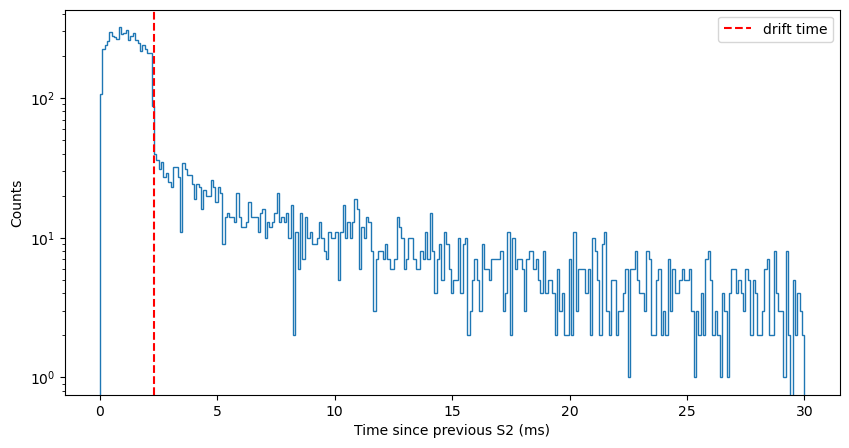

In [18]:
#plotting giant photoionization peak at the beginning
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(se_peaks_assigned["time differences"]*1e-6,bins=np.linspace(0,30,300),histtype="step")
ax.set_xlabel("Time since previous S2 (ms)")
ax.set_ylabel("Counts")
ax.set_yscale("log")
ax.axvline(x=2.3,color='r',linestyle='--',label="drift time")
ax.legend()

#number of SE peaks that are less than and more than 2.3 ms of an S2 peak (i.e. data left from photoionization cut)
print("frac. of se peaks within drift time: ",np.sum(time_diffs_se <= 2.3e6)/len(time_diffs_se))
print("frac. of se peaks outside drift time: ",np.sum(time_diffs_se >= 2.3e6)/len(time_diffs_se))

In [19]:
#x and y position differences between SE and S2 peak directly before it reconstructing 
# using a multi-layer perceptron (MLP) by XENONnT signal processing software  
pos_diffs_x = se_peaks["x_mlp"]-s2_peaks["x_mlp"][assigned_se_indices]
pos_diffs_y = se_peaks["y_mlp"]-s2_peaks["y_mlp"][assigned_se_indices]

#save the position differences in the se_peaks_assigned dataframe
se_peaks_assigned["x_pos differences"] = pos_diffs_x
se_peaks_assigned["y_pos differences"] = pos_diffs_y

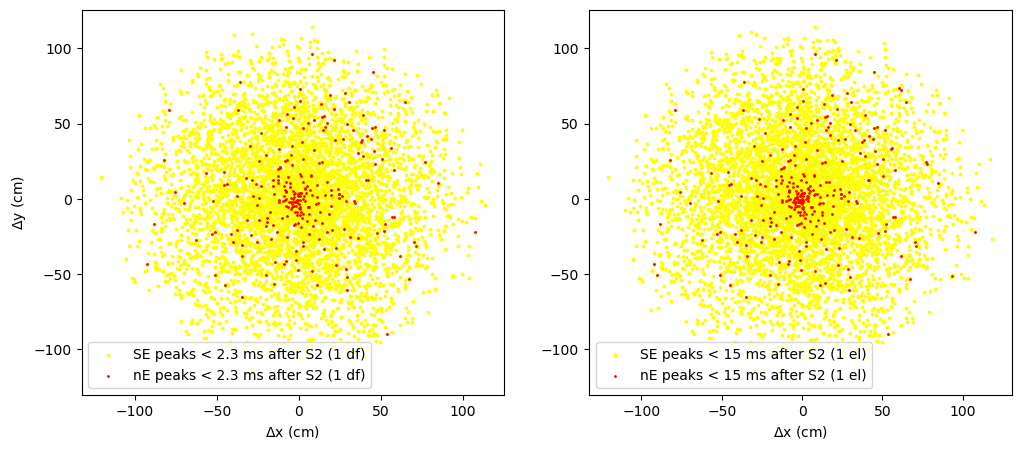

In [20]:
# We should see larger position non-correlations for delayed SEs than prompt SEs
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(pos_diffs_x[time_diffs_se <= 2.3e6],
            pos_diffs_y[time_diffs_se <= 2.3e6],
            color="yellow",s=3,label="SE peaks < 2.3 ms after S2 (1 df)")
ax[0].set_xlabel("$\Delta$x (cm)")
ax[0].set_ylabel("$\Delta$y (cm)")


ax[1].scatter(pos_diffs_x[time_diffs_se <= 15e6],                 #just restricted it here for visibility 
                                                                    #15ms is mean electron lifetime
            pos_diffs_y[time_diffs_se <= 15e6],
            color="yellow",s=3,label="SE peaks < 15 ms after S2 (1 el)")
ax[1].set_xlabel("$\Delta$x (cm)")

#------------------also plotting ne regions separately, since these should be not position correlated

assigned_ne_indices, ne_time_diffs, se_peaks2 = diffs_s2_to_se(s2_peaks,se_peaks2)

pos_diffs_x_ne = se_peaks2["x_mlp"]-s2_peaks["x_mlp"][assigned_ne_indices]
pos_diffs_y_ne = se_peaks2["y_mlp"]-s2_peaks["y_mlp"][assigned_ne_indices]

ax[0].scatter(pos_diffs_x_ne[ne_time_diffs <= 2.3e6],
              pos_diffs_y_ne[ne_time_diffs<= 2.3e6],
              color="red",s=1,label="nE peaks < 2.3 ms after S2 (1 df)")

ax[1].scatter(pos_diffs_x_ne[ne_time_diffs<= 15e6],
              pos_diffs_y_ne[ne_time_diffs<= 15e6],
              color="red",s=1,label="nE peaks < 15 ms after S2 (1 el)")


ax[0].legend()
ax[1].legend()

Text(0, 0.5, 'Distance from S2 (cm)')

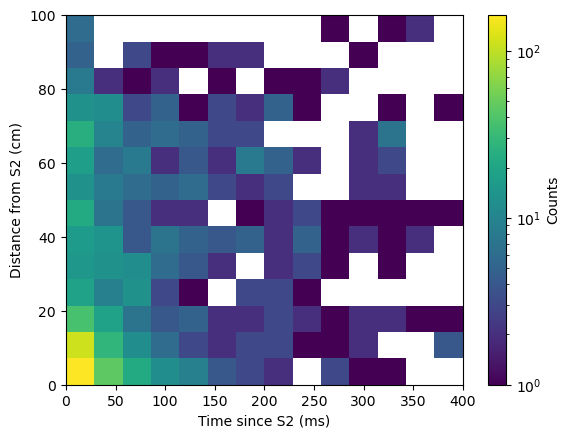

In [21]:
#Choosing delayed SEs
se_assigned_delayed = se_peaks_assigned[se_peaks_assigned["time differences"]*1e-6 > 2.3] 
se_assigned_delayed = se_assigned_delayed.dropna()

#Make a histogram for S2s located in the central region of the detector (r < 40 cm)
#and for SEs that are delayed by more than 2.3 ms
s2_central = s2_peaks_assigned[(s2_peaks["x_mlp"]**2 + s2_peaks_assigned["y_mlp"]**2)**0.5 < 40]
se_central = se_assigned_delayed[se_assigned_delayed["S2 index"].isin(s2_central.index)]

distance_to_s2_central = (se_central["x_pos differences"]**2 + se_central["y_pos differences"]**2)**0.5

plt.hist2d(se_central["time differences"]*1e-6,
           distance_to_s2_central,
           bins=(np.linspace(0,400,15),np.linspace(0,100,15)),
           cmap='viridis',norm=mcolors.LogNorm()
           );
plt.colorbar(label='Counts')

plt.xlabel("Time since S2 (ms)")
plt.ylabel("Distance from S2 (cm)")


Starting with fitting

In [22]:
#define basic functions to use for fitting in this cell
def constant_pdf_ext(t,s,t_min,t_max):
    """Normalized uniform continuous distribution everywhere between t_min and t_max
    
    t = input array of times
    s = scale factor used for extended MLE fitting
    t_min = minimum time value
    t_max = maximum time value
    """
    t = np.asarray(t)
    def segment1(t):
        return 1/(t_max-t_min)
    
    # Apply piecewise function for the PDF
    pdf = np.piecewise(t, 
                       [t < t_min, (t>=t_min) & (t<=t_max), t >= t_max], 
                       [0,segment1,0])
    
    return s,s*pdf

#----------------------

def power_law_pdf1(t,n,t_min):
    """Normalized power law pdf with all values below t_min set to zero
    
    t = array of times to evaluate the pdf at
    n = power law index
    t_min = time below which pdf is zero"""    
    t = np.asarray(t)                 
    pdf_values = np.full((t.shape),0.0)   #did this because otherwise it will calculate the pdf first which is a problem if t=0 is included
    mask = t>=t_min
    pdf_values[mask] = (((n-1)/t_min)*(t[mask]/t_min)**(-n))
    return pdf_values

def power_law_pdf_ext1(t,s,n,k,t_min):
    """Extended power law pdf + some constant with all values below t_min set to zero
    t = array of times to evaluate the pdf at
    s = scale factor used for the extended MLE fit
    n = power law index
    t_min = time below which pdf is zero
    k = constant added to the power law pdf
    """
    t = np.asarray(t)
    return s+k*(np.max(t)-t_min),s*power_law_pdf1(t,n,t_min)+k

#----------------------

def power_law_cdf(t,n,t_min):
    """Normalized cdf of the power law distribution, clipped to make sure it doesn't go over 1
    Can use this for a binned  fit
    
    t = array of times to evaluate the pdf at
    n = power law index
    t_min = time below which pdf is zero"""    
    t = np.asarray(t)
    return (1-(t/t_min)**(-n+1)).clip(0,1)

def power_law_cdf_ext(t,s,n,t_min):
        """Extended cdf of power law distribution, clipped to make sure it doesn't go over 1
    Can use this for an extended binned fit
    
    t = array of times to evaluate the pdf at
    s = scale factor used for the extended MLE fit
    n = power law index
    t_min = time below which pdf is zero
    k = constant added to the power law pdf"""
        
    t = np.asarray(t)
    return s*power_law_cdf(t,n,t_min)


In [23]:
se_delayed_peaks = se_peaks_assigned[se_peaks_assigned["time differences"] > 2.3e6]       #removing prompt electrons

5135


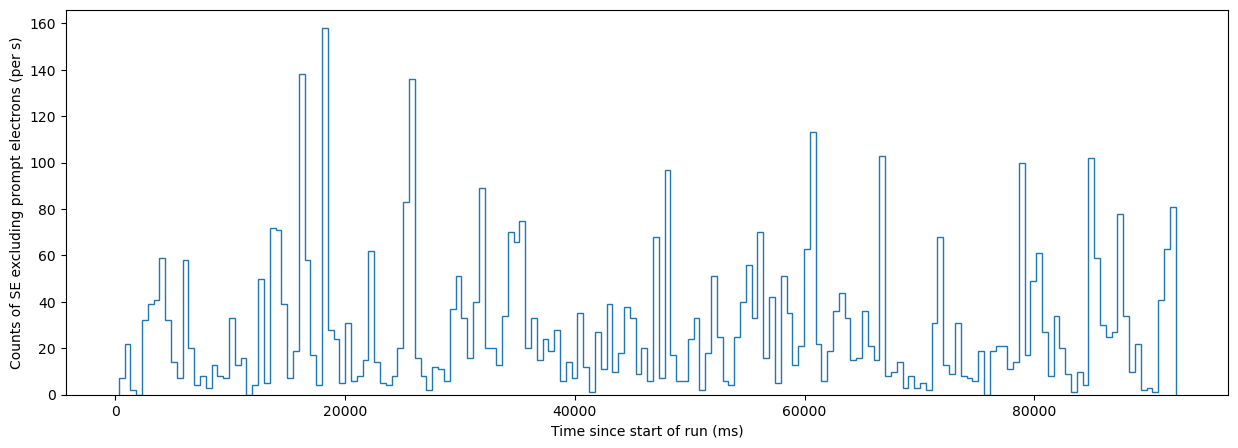

In [24]:
time_to_fit_const = se_delayed_peaks["time since start"]*1e-6
print(len(time_to_fit_const))

resolution_const_ms = 500
n_bins = int((np.max(time_to_fit_const)-np.min(time_to_fit_const))/resolution_const_ms)

hist_const, bin_edges_const = np.histogram(time_to_fit_const, 
                                            bins=np.linspace(np.min(time_to_fit_const),np.max(time_to_fit_const),n_bins))
bin_centers_const = (bin_edges_const[:-1] + bin_edges_const[1:])/2

#plotting just to check
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.hist(bin_centers_const,bins=bin_edges_const,weights=hist_const,histtype="step");
ax.set_xlabel("Time since start of run (ms)")
ax.set_ylabel("Counts of SE excluding prompt electrons (per s)");


In [25]:
c = cost.ExtendedUnbinnedNLL(time_to_fit_const,constant_pdf_ext)
m = Minuit(c,s=2,
           t_min=2.3,t_max=np.max(time_to_fit_const))
m.limits["t_min"] = (2.3,np.max(time_to_fit_const))
bin_fit = m.values
m.interactive()
m.migrad()
neg_log_const = m.fval

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


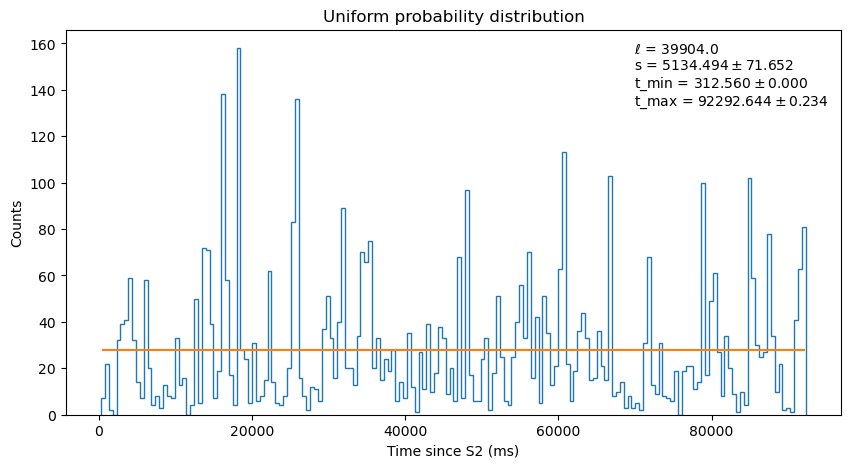

In [26]:
#plotting the fit
#NOTE: this is a limited fit! Doesn't go to zero in the photoionization peak regions. Rate should be interpreted with caution
fig,ax = plt.subplots(1,1,figsize=(10,5))

model_const = constant_pdf_ext(bin_centers_const,s=bin_fit["s"],
                        t_min=bin_fit["t_min"],t_max=bin_fit["t_max"])[1]*resolution_const_ms

ax.hist(bin_centers_const,bins=bin_edges_const,weights=hist_const,histtype="step")
ax.plot(bin_centers_const,model_const)
plt.xlabel("Time since S2 (ms)")
plt.ylabel("Counts")    
plt.title("Uniform probability distribution")

fit_info = [
    f"$\ell$ = {m.fval:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info), frameon=False);

5135


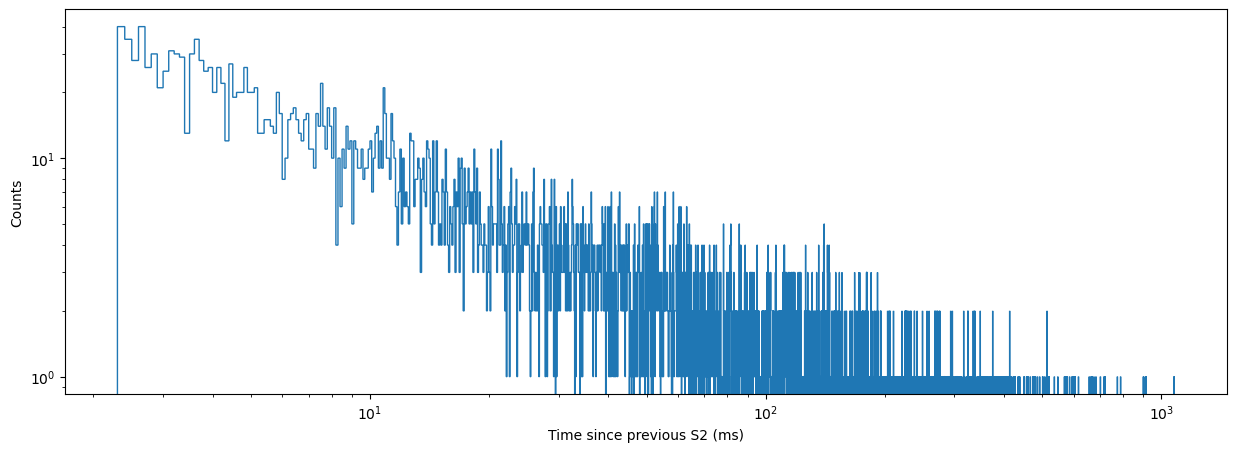

In [27]:
time_to_fit_power = se_delayed_peaks["time differences"]*1e-6   #switching to time differences instead of clock tim
                                                                #to fit the power law function

print(len(time_to_fit_power))

resolution_ms = 0.1

n_bins = int((np.max(time_to_fit_power)-np.min(time_to_fit_power))/resolution_ms)

hist_power, bin_edges_power = np.histogram(time_to_fit_power, bins=np.linspace(np.min(time_to_fit_power),np.max(time_to_fit_power),n_bins))
bin_centers_power = (bin_edges_power[:-1] + bin_edges_power[1:])/2

#plotting just to check
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.hist(bin_centers_power,bins=bin_edges_power,weights=hist_power,histtype="step");
ax.set_xlabel("Time since previous S2 (ms)")
ax.set_ylabel("Counts")
ax.set_xscale("log")
ax.set_yscale("log")


In [28]:
c = cost.ExtendedUnbinnedNLL(time_to_fit_power,power_law_pdf_ext1)
m = Minuit(c,s=9,n=9,k=0,t_min=2.3)
m.fixed["t_min"] = True
m.limits["n"] = (1.1,10)
#m.limits["k"] = (0,None)
bin_fit = m.values
#m.interactive()
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.271e+04                 │              Nfcn = 223              │
│ EDM = 0.000186 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  5.21e3   │  0.08e3   │            │            │         │         │       │
│ 1 │ n     │   1.386   │   0.006   │            │            │   1.1   │   10    │       │
│ 2 │ k     │  -0.072   │   0.029   │            │            │         │         │       │
│ 3 │ t_min │   2.300   │   0.023   │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────┐
│       │          s          n          k      t_min │
├───────┼─────────────────────────────────────────────┤
│     s │   6.43e+03 -77.587e-3    -1.0480        0e3 │
│     n │ -77.587e-3   3.38e-05   0.065e-3          0 │
│     k │    -1.0480   0.065e-3    0.00087          0 │
│ t_min │        0e3          0          0          0 │
└───────┴─────────────────────────────────────────────┘

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


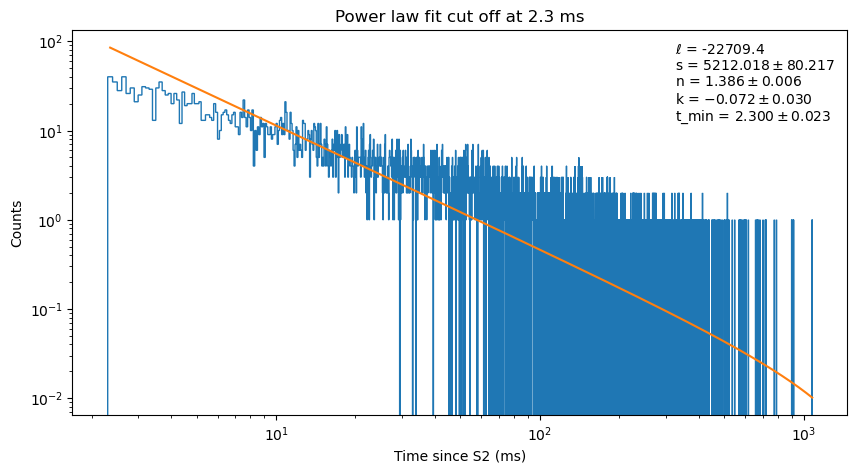

In [29]:
#plotting the fit
fig,ax = plt.subplots(1,1,figsize=(10,5))

model = power_law_pdf_ext1(bin_centers_power,s=bin_fit["s"],k=bin_fit["k"],
        n=bin_fit["n"],t_min=bin_fit["t_min"])[1]*resolution_ms

ax.hist(bin_centers_power,bins=bin_edges_power,weights=hist_power,histtype="step")
ax.plot(bin_centers_power,model)
ax.set_xscale("log")
ax.set_yscale("log")
plt.xlabel("Time since S2 (ms)")
plt.ylabel("Counts")
plt.title("Power law fit cut off at 2.3 ms")

fit_info = [
    f"$\ell$ = {m.fval:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info), frameon=False)


In [30]:
def broken_power_law_pdf(t,s,k,n1, n2, t_min, t_b):
    """Normalized broken power law pdf with all values below t_min set to zero. Use to find
    any changes in gradient of the power law distribution
    
    t = array of times to evaluate the pdf at
    s = scale factor to be used for the extended MLE fit
    k = constant added to the power law pdf
    n1 = power law index before the break
    n2 = power law index after the break
    t_min = time below which pdf is zero
    t_b = time at which the power law changes"""
    t = np.asarray(t)
    x1 = (t_b**(1-n1))/(1-n1)
    x2 = (t_min**(1-n1))/(n1-1) 
    x3 = (t_b**(1-n1))/(n2-1)
    a = 1/(x1+x2+x3)

    def segment1(t):
        pdf1 = np.full(t.shape,0.0)   #did this because otherwise it will calculate the pdf first which is a problem if t=0 is included
        mask = t>=t_min
        pdf1[mask] = a*(t[mask])**(-n1)
        return pdf1
    
    def segment2(t):
        return a*((t_b)**(n2-n1))*((t)**(-n2))
    
    # Apply piecewise function for the CDF
    pdf = np.piecewise(t, 
                       [t < t_b, t >= t_b], 
                       [segment1, segment2])
    
    return s+k*(np.max(t)-t_min),s*pdf+k


In [31]:
#fitting the broken power law pdf
c = cost.ExtendedUnbinnedNLL(time_to_fit_power,broken_power_law_pdf)
m = Minuit(c,s=len(time_to_fit_power),k=10,n1=1.3,n2=1.1,
           t_min=2.3,t_b=10)
m.fixed["t_min"] = True
m.limits["t_b"] = (2.3,np.max(time_to_fit_power))
broken_fit = m.values

m.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.536e+04                 │              Nfcn = 672              │
│ EDM = 3.02e-05 (Goal: 0.0002)    │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  5.14e3   │  0.07e3   │            │            │         │         │       │
│ 1 │ k     │  -0.001   │   0.013   │            │            │         │         │       │
│ 2 │ n1    │   0.938   │   0.011   │            │            │         │         │       │
│ 3 │ n2    │   3.12    │   0.09    │            │            │         │         │       │
│ 4 │ t_min │   2.300   │   0.023   │            │            │         │         │  yes  │
│ 5 │ t_b   │   180.3   │    2.2    │            │            │   2.3   │ 1078.06 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────────────────┐
│       │          s          k         n1         n2      t_min        t_b │
├───────┼───────────────────────────────────────────────────────────────────┤
│     s │   5.34e+03 -175.82e-3   -8.75e-3     -0.643        0e3         -8 │
│     k │ -175.82e-3    0.00016          0    0.63e-3          0    1.49e-3 │
│    n1 │   -8.75e-3          0   0.000121   -0.20e-3          0    4.31e-3 │
│    n2 │     -0.643    0.63e-3   -0.20e-3     0.0076      0.000      0.052 │
│ t_min │        0e3          0          0      0.000          0          0 │
│   t_b │         -8    1.49e-3    4.31e-3      0.052          0       4.97 │
└───────┴───────────────────────────────────────────────────────────────────┘

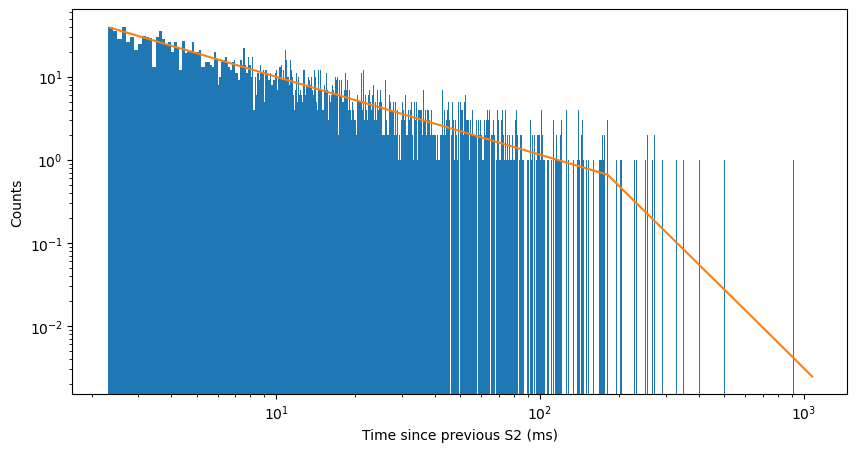

In [32]:
#plotting the fit
fig,ax = plt.subplots(1,1,figsize=(10,5))
model = broken_power_law_pdf(bin_centers_power,
        s=broken_fit["s"],n1=broken_fit["n1"],n2=broken_fit["n2"],k=broken_fit["k"],
        t_min=broken_fit["t_min"],t_b=broken_fit["t_b"])[1]*resolution_ms
ax.hist(bin_centers_power,bins=bin_edges_power,weights=hist_power,label="data")
ax.plot(bin_centers_power,model,label="Fit from cdf")
ax.set_xscale("log")
ax.set_yscale("log")

fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


#plt.legend(title="\n".join(fit_info), frameon=False)
plt.xlabel("Time since previous S2 (ms)")
plt.ylabel("Counts");

#so it looks like it puts the break where the data starts to become ~1 per bin
#what happens with more data? hmm

Studying Double Scatters

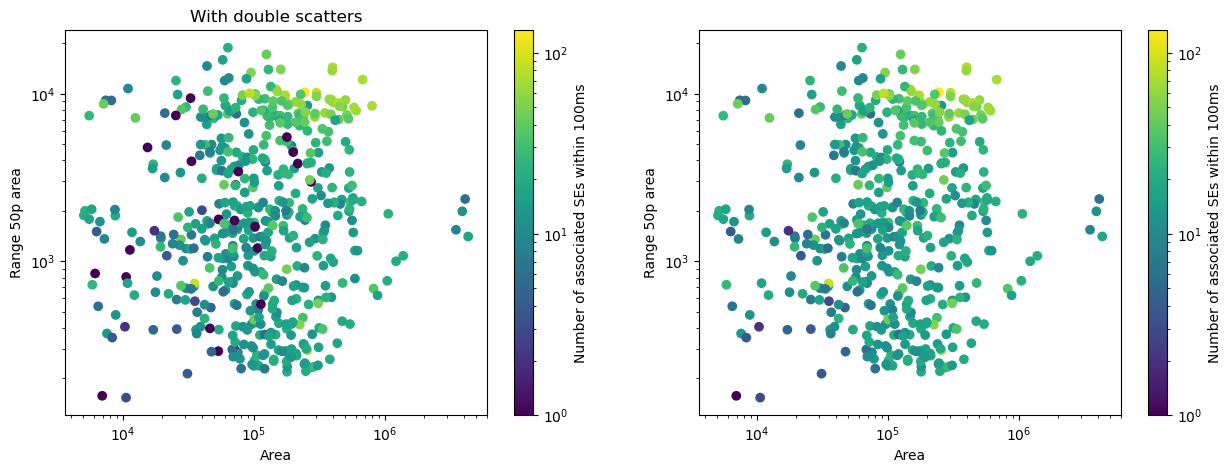

In [124]:
s2_peaks_exc_peak1 = s2_peaks_assigned[s2_peaks_assigned["livetime windows"] > 2.3]  #all peaks + second peak of double scatters

s2_peaks_ds_peak1 = s2_peaks_assigned[s2_peaks_assigned["livetime windows"] <= 2.3]  #all double scatters first peak

s2_peaks_ds_peak2 = s2_peaks_assigned.loc[s2_peaks_ds_peak1.index + 1]              #all double scatters second peak

no_ds_index = s2_peaks_exc_peak1.index.difference(s2_peaks_ds_peak2.index) 
s2_peaks_exc_ds = s2_peaks_exc_peak1.loc[no_ds_index]                              #all S2s dropping double scatters altogether

#seeing how associated SEs change with area and width
fig,ax = plt.subplots(1,2,figsize=(15,5))
scatter1 = ax[0].scatter(s2_peaks_assigned["area"], s2_peaks["range_50p_area"],
            c=s2_peaks_assigned["total SE"], cmap='viridis', norm=mcolors.LogNorm())
cbar = plt.colorbar(scatter1,ax=ax[0])
cbar.set_label("Number of associated SEs within 100ms")
ax[0].set_xlabel("Area")
ax[0].set_ylabel("Range 50p area")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title("With double scatters")

scatter2 = ax[1].scatter(s2_peaks_exc_peak1["area"], s2_peaks_exc_peak1["range_50p_area"],
            c=s2_peaks_exc_peak1["total SE"], cmap='viridis', norm=mcolors.LogNorm())
cbar = plt.colorbar(scatter2,ax=ax[1])
cbar.set_label("Number of associated SEs within 100ms")
ax[1].set_xlabel("Area")
ax[1].set_ylabel("Range 50p area")
ax[1].set_xscale('log')
ax[1].set_yscale('log')

#so we gotta remove double scatters to get some nice fits for peaks!!

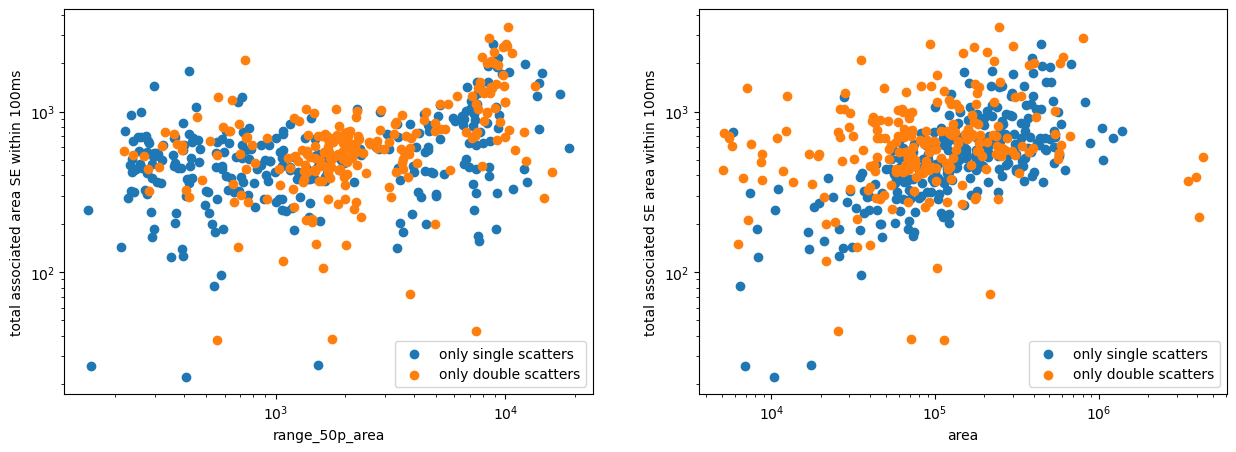

In [123]:
#seeing how it is different for single vs. double scatters
fig,ax = plt.subplots(1,2,figsize=(15,5))

x= np.asarray(s2_peaks_ds_peak2["range_50p_area"])+np.asarray(s2_peaks_ds_peak1["range_50p_area"])
y = np.asarray(s2_peaks_ds_peak1["area"]) + np.asarray(s2_peaks_ds_peak2["area"])

ax[0].scatter(s2_peaks_exc_ds["range_50p_area"],s2_peaks_exc_ds["SE area total"],label="only single scatters")
ax[0].scatter(s2_peaks_ds_peak2["range_50p_area"],s2_peaks_ds_peak2["SE area total"],label="only double scatters")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("range_50p_area")
ax[0].set_ylabel("total associated area SE within 100ms")
ax[0].legend()

ax[1].scatter(s2_peaks_exc_ds["area"],s2_peaks_exc_ds["SE area total"],label="only single scatters")
ax[1].scatter(s2_peaks_ds_peak2["area"],s2_peaks_ds_peak2["SE area total"],label="only double scatters")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("area")
ax[1].set_ylabel("total associated SE area within 100ms")
ax[1].legend()

In [29]:
print(len(s2_peaks_assigned.index))
print(len(s2_peaks_exc_peak1.index))
print(len(s2_peaks_ds_peak1.index))
print(len(s2_peaks_ds_peak2.index))
print(len(s2_peaks_exc_ds.index))
#one missing because i.g. the last entry you do not know if it is a double scatter or not?

828
491
336
336
272


Trying the same thing but without double scatters

In [30]:
#new assignment of the SEs to the second peak of each double scatter
assigned_se_exc_ds,time_diffs_exc_ds,se_peaks_exc_ds= diffs_s2_to_se(s2_peaks_exc_peak1.reset_index(),se_peaks)

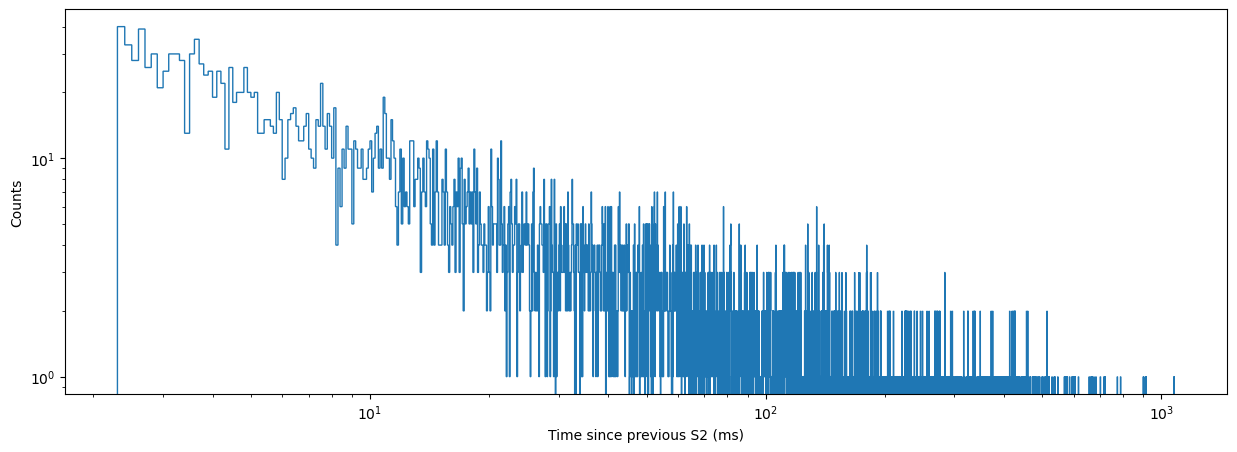

In [31]:
time_diffs_exc_ds_delayed = time_diffs_exc_ds[time_diffs_exc_ds > 2.3e6]/1e6 

resolution_ms = 0.1

n_bins = int((np.max(time_diffs_exc_ds_delayed)-np.min(time_diffs_exc_ds_delayed))/resolution_ms)

hist_power_exc_ds, bin_edges_power_exc_ds = np.histogram(time_diffs_exc_ds_delayed, bins=np.linspace(np.min(time_diffs_exc_ds_delayed),
                                                                                                    np.max(time_diffs_exc_ds_delayed),n_bins))
bin_centers_power_exc_ds = (bin_edges_power_exc_ds[:-1] + bin_edges_power_exc_ds[1:])/2

#plotting just to check
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.hist(bin_centers_power_exc_ds,bins=bin_edges_power_exc_ds,weights=hist_power_exc_ds,histtype="step");
ax.set_xlabel("Time since previous S2 (ms)")
ax.set_ylabel("Counts")
ax.set_xscale("log")
ax.set_yscale("log")

In [32]:
c = cost.ExtendedUnbinnedNLL(time_diffs_exc_ds_delayed,power_law_pdf_ext1)
m = Minuit(c,s=9,n=9,k=0,t_min=2.3)
m.fixed["t_min"] = True
m.limits["n"] = (None,50)
bin_fit = m.values
#m.interactive()
m.migrad()
neg_log_power = m.fval

C:\Users\keert\AppData\Local\Temp\ipykernel_37144\95160620.py:21: RuntimeWarning: overflow encountered in power
  pdf_values[mask] = (((n-1)/t_min)*(t[mask]/t_min)**(-n))
C:\Users\keert\AppData\Local\Temp\ipykernel_37144\95160620.py:21: RuntimeWarning: overflow encountered in multiply
  pdf_values[mask] = (((n-1)/t_min)*(t[mask]/t_min)**(-n))
C:\Users\keert\AppData\Local\Temp\ipykernel_37144\95160620.py:26: RuntimeWarning: overflow encountered in multiply
  return s+k*(np.max(t)-t_min),s*power_law_pdf1(t,n,t_min)+k


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


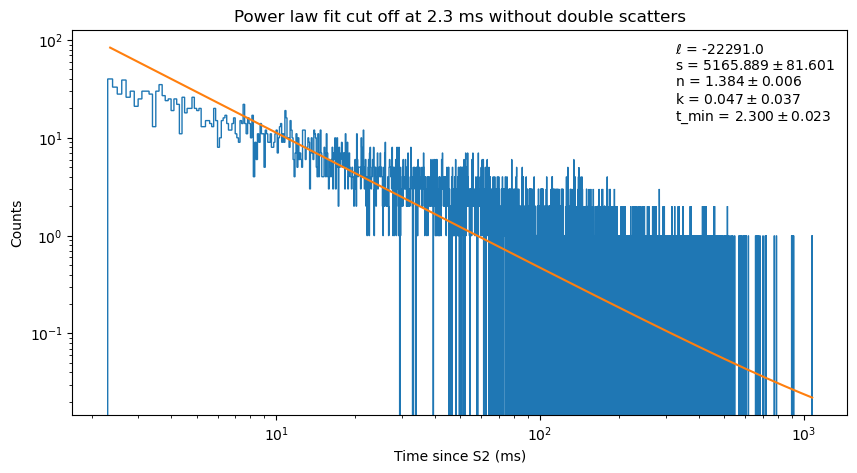

In [33]:
#plotting the fit
fig,ax = plt.subplots(1,1,figsize=(10,5))

model = power_law_pdf_ext1(bin_centers_power_exc_ds,s=bin_fit["s"],k=bin_fit["k"],
        n=bin_fit["n"],t_min=bin_fit["t_min"])[1]*resolution_ms

ax.hist(bin_centers_power_exc_ds,bins=bin_edges_power_exc_ds,weights=hist_power_exc_ds,histtype="step")
ax.plot(bin_centers_power_exc_ds,model)
ax.set_xscale("log")
ax.set_yscale("log")
plt.xlabel("Time since S2 (ms)")
plt.ylabel("Counts")
plt.title("Power law fit cut off at 2.3 ms without double scatters")

fit_info = [
    f"$\ell$ = {m.fval:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info), frameon=False)


In [34]:
#fitting the broken power law pdf
c = cost.ExtendedUnbinnedNLL(time_diffs_exc_ds_delayed,broken_power_law_pdf)
m = Minuit(c,s=len(time_to_fit_power),k=10,n1=1.3,n2=1.1,
           t_min=2.3,t_b=10)
m.fixed["t_min"] = True
m.limits["t_b"] = (2.3,np.max(time_to_fit_power))
broken_fit = m.values

m.migrad(ncall=1500)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.503e+04                 │             Nfcn = 1470              │
│ EDM = 0.000578 (Goal: 0.0002)    │            time = 2.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  5.23e3   │  0.07e3   │            │            │         │         │       │
│ 1 │ k     │  -0.013   │   0.014   │            │            │         │         │       │
│ 2 │ n1    │   0.920   │   0.012   │            │            │         │         │       │
│ 3 │ n2    │   2.90    │   0.08    │            │            │         │         │       │
│ 4 │ t_min │   2.300   │   0.023   │            │            │         │         │  yes  │
│ 5 │ t_b   │   180.6   │    3.3    │            │            │   2.3   │ 1078.06 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────────────────┐
│       │          s          k         n1         n2      t_min        t_b │
├───────┼───────────────────────────────────────────────────────────────────┤
│     s │   5.42e+03 -173.26e-3   -9.65e-3     -0.732        0e3         -7 │
│     k │ -173.26e-3   0.000199          0    0.71e-3          0    3.36e-3 │
│    n1 │   -9.65e-3          0   0.000144   -0.14e-3          0    9.16e-3 │
│    n2 │     -0.732    0.71e-3   -0.14e-3    0.00638      0.000      0.095 │
│ t_min │        0e3          0          0      0.000          0          0 │
│   t_b │         -7    3.36e-3    9.16e-3      0.095          0       11.1 │
└───────┴───────────────────────────────────────────────────────────────────┘

C:\Users\keert\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\keert\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\keert\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\keert\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\keert\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amoun

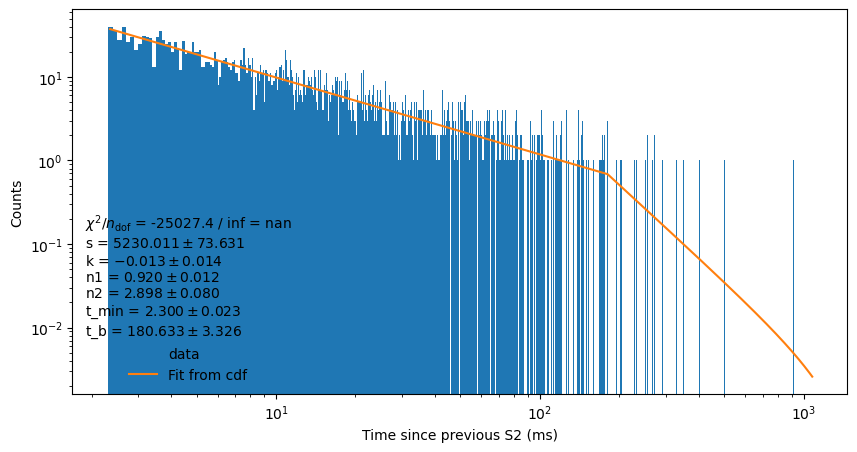

In [35]:
#plotting the fit
fig,ax = plt.subplots(1,1,figsize=(10,5))
model = broken_power_law_pdf(bin_centers_power,
        s=broken_fit["s"],n1=broken_fit["n1"],n2=broken_fit["n2"],k=broken_fit["k"],
        t_min=broken_fit["t_min"],t_b=broken_fit["t_b"])[1]*resolution_ms
ax.hist(bin_centers_power,bins=bin_edges_power,weights=hist_power,label="data")
ax.plot(bin_centers_power,model,label="Fit from cdf")
ax.set_xscale("log")
ax.set_yscale("log")

fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


ax.legend(title="\n".join(fit_info), frameon=False)
ax.set_xlabel("Time since previous S2 (ms)")
ax.set_ylabel("Counts");



Cumulative power law

In [196]:
#Select data points S2s and the SEs after it for fitting.

#If you change the indices in the following line, the code automatically updates the data points
#Use this for visualizing specific sections of the fit

s2_test_data = s2_peaks_assigned[250:259]
se_test_data = se_delayed_peaks[se_delayed_peaks['S2 index'].isin(s2_test_data.index)]

#t_differences_all = pd.DataFrame(se_test_data["time"][:,None] - s2_test_data["time"][None,:]) 
#s2_start = t_differences_all[s2_test_data.index[0]]
#print(t_differences_all.shape)

s2_test_data["time since start"] = (s2_test_data["time"]-s2_test_data["time"].min())
se_test_data_start = (se_test_data["time"]-s2_test_data["time"].min())/1e6

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


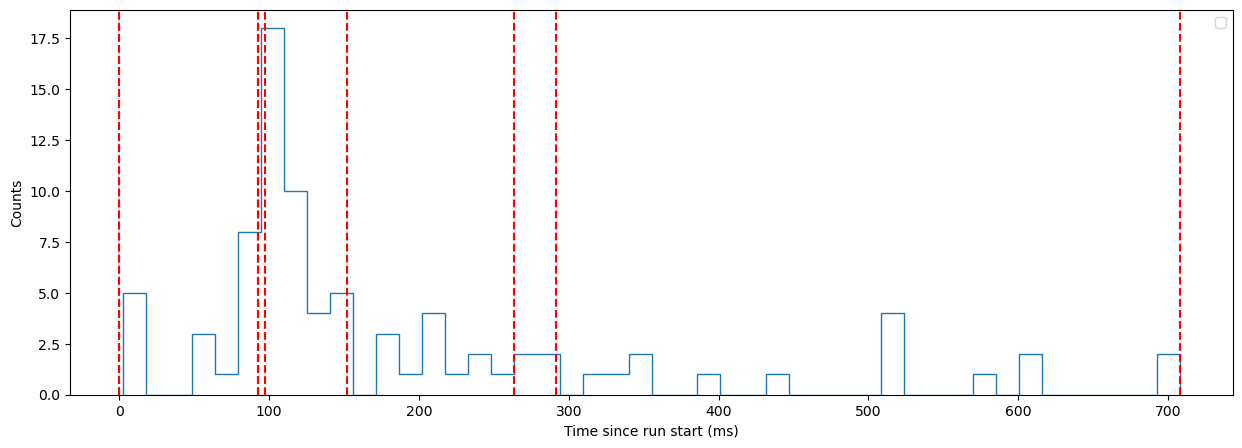

In [197]:
#plotting the single elctrons after the selected peaks
fig,ax = plt.subplots(1,1,figsize=(15,5))

resolution_power_sum_ms = 15
n_bins = int((np.max(se_test_data_start)-np.min(se_test_data_start))/resolution_power_sum_ms)

hist_power_sum, bin_edges_power_sum = np.histogram(se_test_data_start, 
                                            bins=np.linspace(np.min(se_test_data_start),
                                                             np.max(se_test_data_start),n_bins))

bin_centers_power_sum = (bin_edges_power_sum[:-1] + bin_edges_power_sum[1:])/2


ax.hist(bin_centers_power_sum,bins=bin_edges_power_sum,weights=hist_power_sum,histtype="step");
for x in s2_test_data["time since start"]/1e6:
    ax.axvline(x,color='r', linestyle='--');

ax.set_xlabel("Time since run start (ms)")
ax.set_ylabel("Counts")
ax.set_ylabel("Counts")
ax.legend()

In [170]:
def multiple_power_law_pdf(t, s, a, tmin, s2_peaks,c,d,k):
    """"
    Returns (s, pdf) for a multiple power law model with a single power law component for each S2 peak.

    Arguments:
     - t: array (n_single_electrons), time since first large peak in ms
     - s: float, scale factor, (total amount of single electrons, sum over entire dataset)
     - a: float, power law index
     - tmin: float, minimum time after S2s. Assumes cut has already been applied
     - s2_peaks: dataframe, large S2 peaks. Time can be in ns.
     - c: float, area exponent, determines how differential rate scales with area
     - d: float, width exponent scales differential rate with [width in ms]
    """
     
    # Find time differences of SE peaks w.r.t each S2 peak 
    # shape (n_single_electrons, n_s2s)
    s2_times = s2_peaks["time since start"].values/1e6
    t_all = np.asarray(t[:,None] - s2_times[None,:])

    # Keep only differences where the SE is later
    mask = t_all >= tmin
    
    # Evaluate power law for each SE - S2 combination
    # Used np.full since otherwise it will calculate the pdf first 
    # which is a problem if t=0 is included
    pdf_values = np.full_like(t_all,0.0)
    pdf_values[mask] = ((a - 1) / tmin) * (t_all[mask] /tmin) ** (-a)
    
    # Compute total number of SEs contributed by each S2
    # (scales the power law differential rate)
    n = s * np.asarray((s2_peaks["area"].values**c)*((s2_peaks["range_50p_area"].values/1e6)**d))
    differential_rate = np.sum(n*pdf_values,axis=1)
    
    return n.sum() + k*(np.max(t)-np.min(t)), differential_rate+k



In [179]:
# Fix s2_peak and s2_time, create cost function
def to_fit(t,s,a,tmin,c,d,k):
    """Just a wrap around function to set s2_peaks"""
    s2_peaks = s2_test_data
    return multiple_power_law_pdf(t, s, a, tmin, s2_peaks,c,d,k)

c = cost.ExtendedUnbinnedNLL(np.asarray(se_test_data_start), to_fit)
m = Minuit(c,s=20e-10,a=1.1,tmin=2.3,c=1,d=1,k=0)
m.limits["a"] = (1.0001,5)
#m.limits["c"] = (-5,5)
#m.limits["d"] = (-5,5)
m.limits["k"] = (0,100)	
m.fixed["tmin"] = True
m.migrad(ncall=5000)
#m.interactive()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.065e+04                  │             Nfcn = 1720              │
│ EDM = 6.1e-05 (Goal: 0.0002)     │           time = 218.4 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s    │   0.63    │   0.12    │            │            │         │         │       │
│ 1 │ a    │   1.383   │   0.008   │            │            │ 1.0001  │    5    │       │
│ 2 │ tmin │   2.300   │   0.023   │            │            │         │         │  yes  │
│ 3 │ c    │   0.908   │   0.008   │            │            │         │         │       │
│ 4 │ d    │   1.625   │   0.018   │            │            │         │         │       │
│ 5 │ k    │  17.3e-3  │  0.7e-3   │            │            │    0    │   100   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬───────────────────────────────────────────────────────┐
│      │        s        a     tmin        c        d        k │
├──────┼───────────────────────────────────────────────────────┤
│    s │   0.0134  0.03e-3    0.000 -0.87e-3  2.07e-3   1.8e-6 │
│    a │  0.03e-3 7.17e-05        0        0        0  -2.4e-6 │
│ tmin │    0.000        0        0        0        0        0 │
│    c │ -0.87e-3        0        0 5.88e-05 -0.13e-3  -0.5e-6 │
│    d │  2.07e-3        0        0 -0.13e-3 0.000328   0.7e-6 │
│    k │   1.8e-6  -2.4e-6        0  -0.5e-6   0.7e-6 4.56e-07 │
└──────┴───────────────────────────────────────────────────────┘

In [199]:
def cum_power_model_val(t,p):
    """Just a wrap around function to set the values of the parameters"""
    s,a,tmin,c,d,k = p
    return to_fit(bin_centers_power_sum,s,a,tmin,c,d,k)

model, model_errors = propagate(lambda p: cum_power_model_val(bin_centers_power_sum,p)[1],
                                m.values,m.covariance)
model_errors_prop = np.diag(model_errors)**0.5


n_val = m.values["s"]*s2_test_data["area"]**m.values["c"]*(s2_test_data["range_50p_area"]/1e6)**m.values["d"]


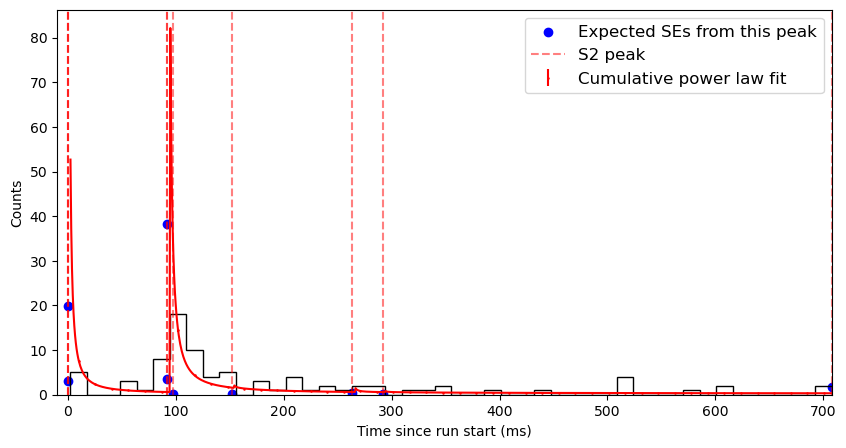

In [200]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(se_test_data_start, bins=bin_edges_power_sum,color="k", histtype='step')


x = np.linspace(np.min(se_test_data_start),np.max(se_test_data_start),1000)
s,p = multiple_power_law_pdf(x,m.values[0],m.values[1],m.values[2],
                             s2_test_data,m.values[3],m.values[4],m.values[5])
ax.errorbar(bin_centers_power_sum,model*resolution_power_sum_ms,yerr=model_errors_prop*resolution_power_sum_ms,fmt="ro",markersize=0.8,label="Cumulative power law fit")
ax.plot(x,p*resolution_power_sum_ms,color="r")
ax.set_xlim(-10,np.max(se_test_data_start))
ax.set_ylabel("Counts")
ax.set_xlabel("Time since run start (ms)")
ax.scatter(s2_test_data["time since start"]/1e6,n_val,color="b",label="Expected SEs from this peak")
for x in s2_test_data["time since start"]/1e6:
    ax.axvline(x,color='r', linestyle='--',alpha=0.5);

ax.axvline(s2_test_data["time since start"].iloc[0]/1e6,color='r', linestyle='--',alpha=0.5,label="S2 peak")
ax.legend(fontsize="large")
